In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white", palette=None,rc={'figure.figsize':(11.7,8.27)})
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,StandardScaler

from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor,VotingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

# **Loading Data**

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')
train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


# **EDA**

In [3]:
train.drop(["id"],axis=1,inplace=True)
train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      186081 non-null  object
 10  clean_title   167114 non-null  object
 11  price         188533 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 17.3+ MB


In [5]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
model_year,188533.0,2015.829998,5.660967,1974.0,2013.0,2017.0,2020.0,2024.0
milage,188533.0,65705.295174,49798.158076,100.0,24115.0,57785.0,95400.0,405000.0
price,188533.0,43878.016178,78819.522254,2000.0,17000.0,30825.0,49900.0,2954083.0


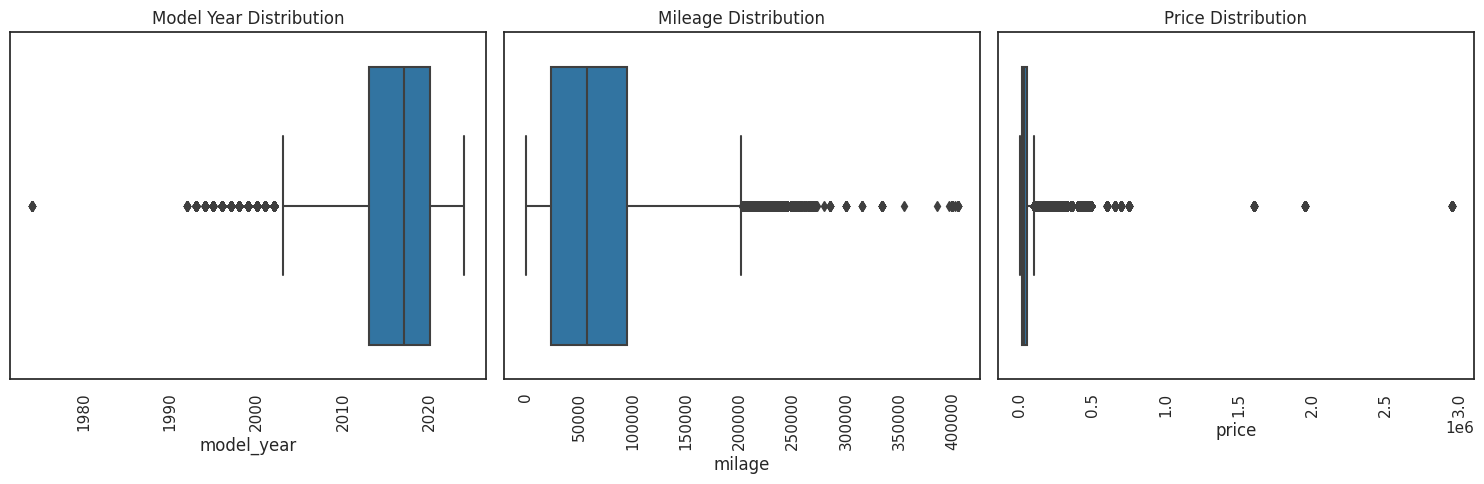

In [6]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=train, x="model_year")
plt.title("Model Year Distribution")
plt.xticks(rotation=90)


plt.subplot(1, 3, 2)
sns.boxplot(data=train, x="milage")
plt.title("Mileage Distribution")
plt.xticks(rotation=90)


plt.subplot(1, 3, 3)
sns.boxplot(data=train, x="price")
plt.title("Price Distribution")
plt.xticks(rotation=90)



plt.tight_layout()
plt.show()

In [7]:
train.describe(include="object")

,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
count,188533,188533,183450,188533,188533,188533,188533,186081,167114
unique,57,1897,7,1117,52,319,156,2,1
top,Ford,F-150 XLT,Gasoline,355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes
freq,23088,2945,165940,3462,49904,48658,107674,144514,167114


In [8]:
train_missing=train.isnull().sum()
train_missing

brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

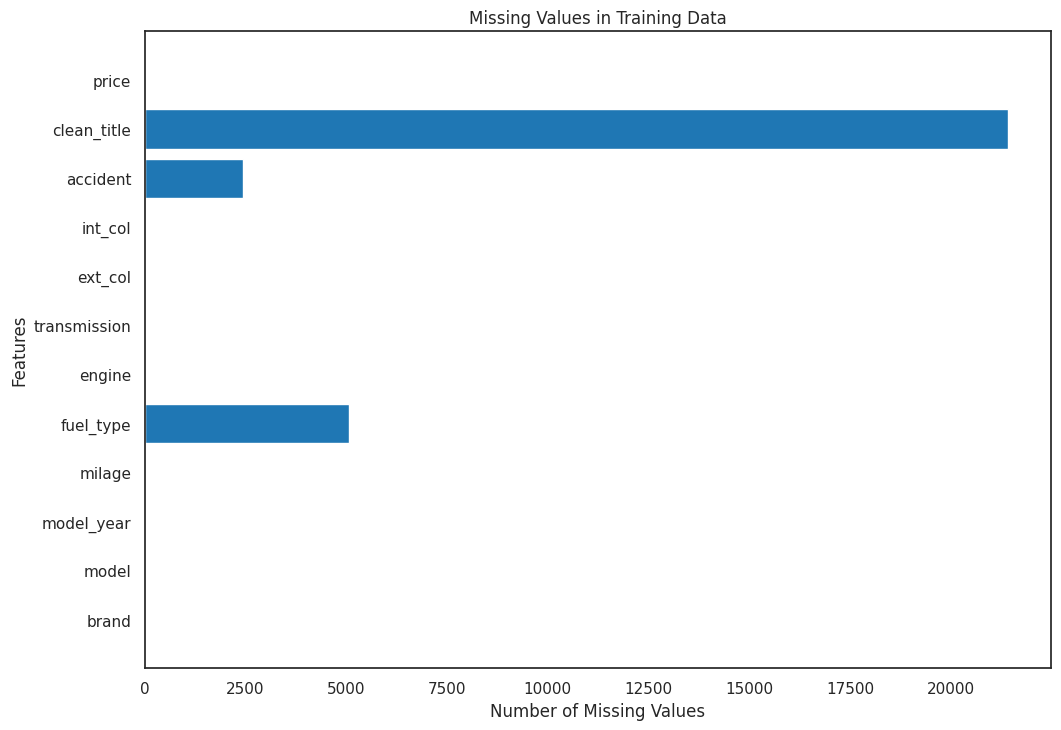

In [9]:
plt.barh(train_missing.index,train_missing.values)
plt.title("Missing Values in Training Data")
plt.xlabel("Number of Missing Values")
plt.ylabel("Features")
plt.show()

In [10]:
train.duplicated().sum()

0

In [11]:
train.brand.value_counts()

brand
Ford             23088
Mercedes-Benz    19172
BMW              17028
Chevrolet        16335
Audi             10887
Porsche          10612
Land              9525
Toyota            8850
Lexus             8643
Jeep              6474
Cadillac          4674
RAM               4249
Nissan            3930
Tesla             3738
INFINITI          3276
GMC               3215
Dodge             3133
Mazda             2719
Kia               2497
Lincoln           2423
Subaru            2381
Acura             2282
Honda             2101
Hyundai           2045
Volkswagen        1765
Jaguar            1319
Bentley           1155
MINI              1064
Genesis            969
Buick              940
Maserati           939
Lamborghini        809
Chrysler           727
Volvo              723
Alfa               682
Rivian             590
Rolls-Royce        561
Mitsubishi         551
Pontiac            538
Hummer             520
Ferrari            359
McLaren            243
Aston              238
Satur

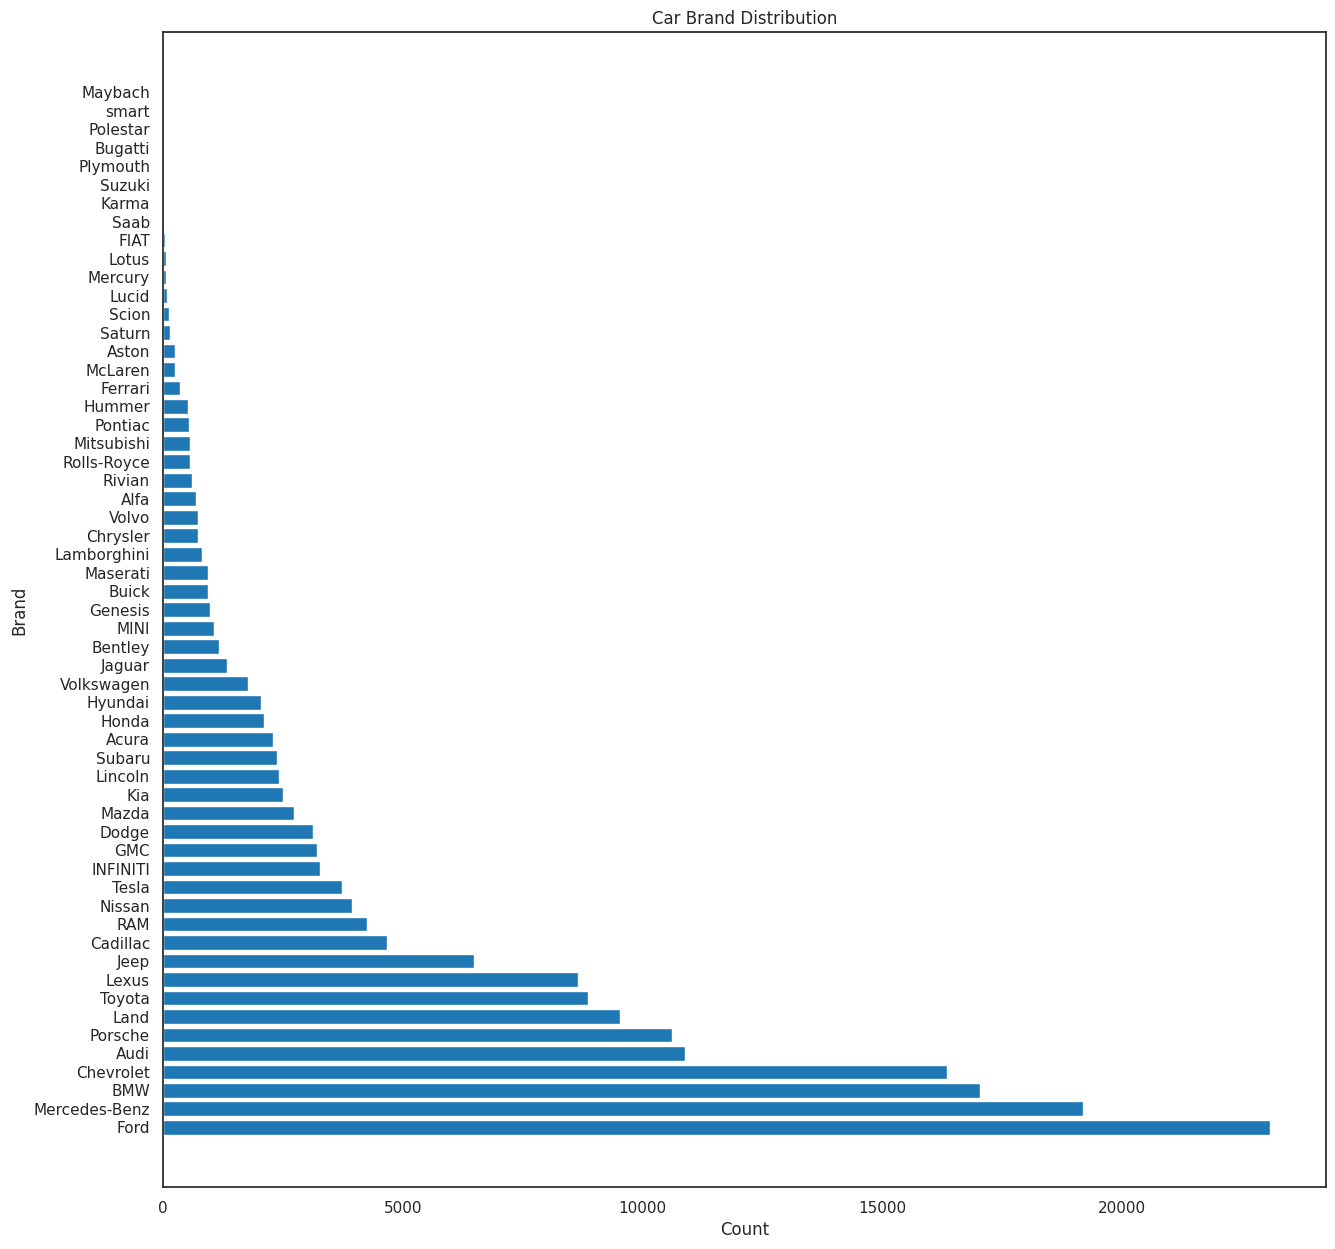

In [12]:
plt.figure(figsize=(15, 15))
plt.barh(train.brand.value_counts().index, train.brand.value_counts().values)
plt.title("Car Brand Distribution")
plt.xlabel("Count")
plt.ylabel("Brand")
plt.show()

In [13]:
train_df=train[(train["brand"]=="Ford") | (train["brand"]=="Mercedes-Benz") |(train["brand"]=="BMW")]
train_df

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500
8,Ford,F-150 XLT,2020,38352,Gasoline,2.7L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Snowflake White Pearl Metallic,Black,None reported,Yes,62890
9,BMW,M4 Base,2015,74850,Gasoline,425.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Black,Blue,None reported,Yes,4000
15,Mercedes-Benz,AMG C 63 S,2017,41500,Gasoline,503.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,None reported,Yes,44900
19,Mercedes-Benz,AMG C 63 Base,2019,16002,Gasoline,469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,9-Speed A/T,White,Red,At least 1 accident or damage reported,Yes,46900
...,...,...,...,...,...,...,...,...,...,...,...,...
188520,Mercedes-Benz,GLC 300 GLC 300,2022,18031,Gasoline,2.0 Liter Turbo,Automatic,White,Black,None reported,NaN,39998
188521,BMW,M240 i xDrive,2019,32000,Gasoline,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,6-Speed M/T,White,Black,None reported,Yes,36300
188523,BMW,328 i,2011,239000,Gasoline,230.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,6-Speed A/T,Black,Black,None reported,Yes,8000
188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600,Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,At least 1 accident or damage reported,Yes,30000


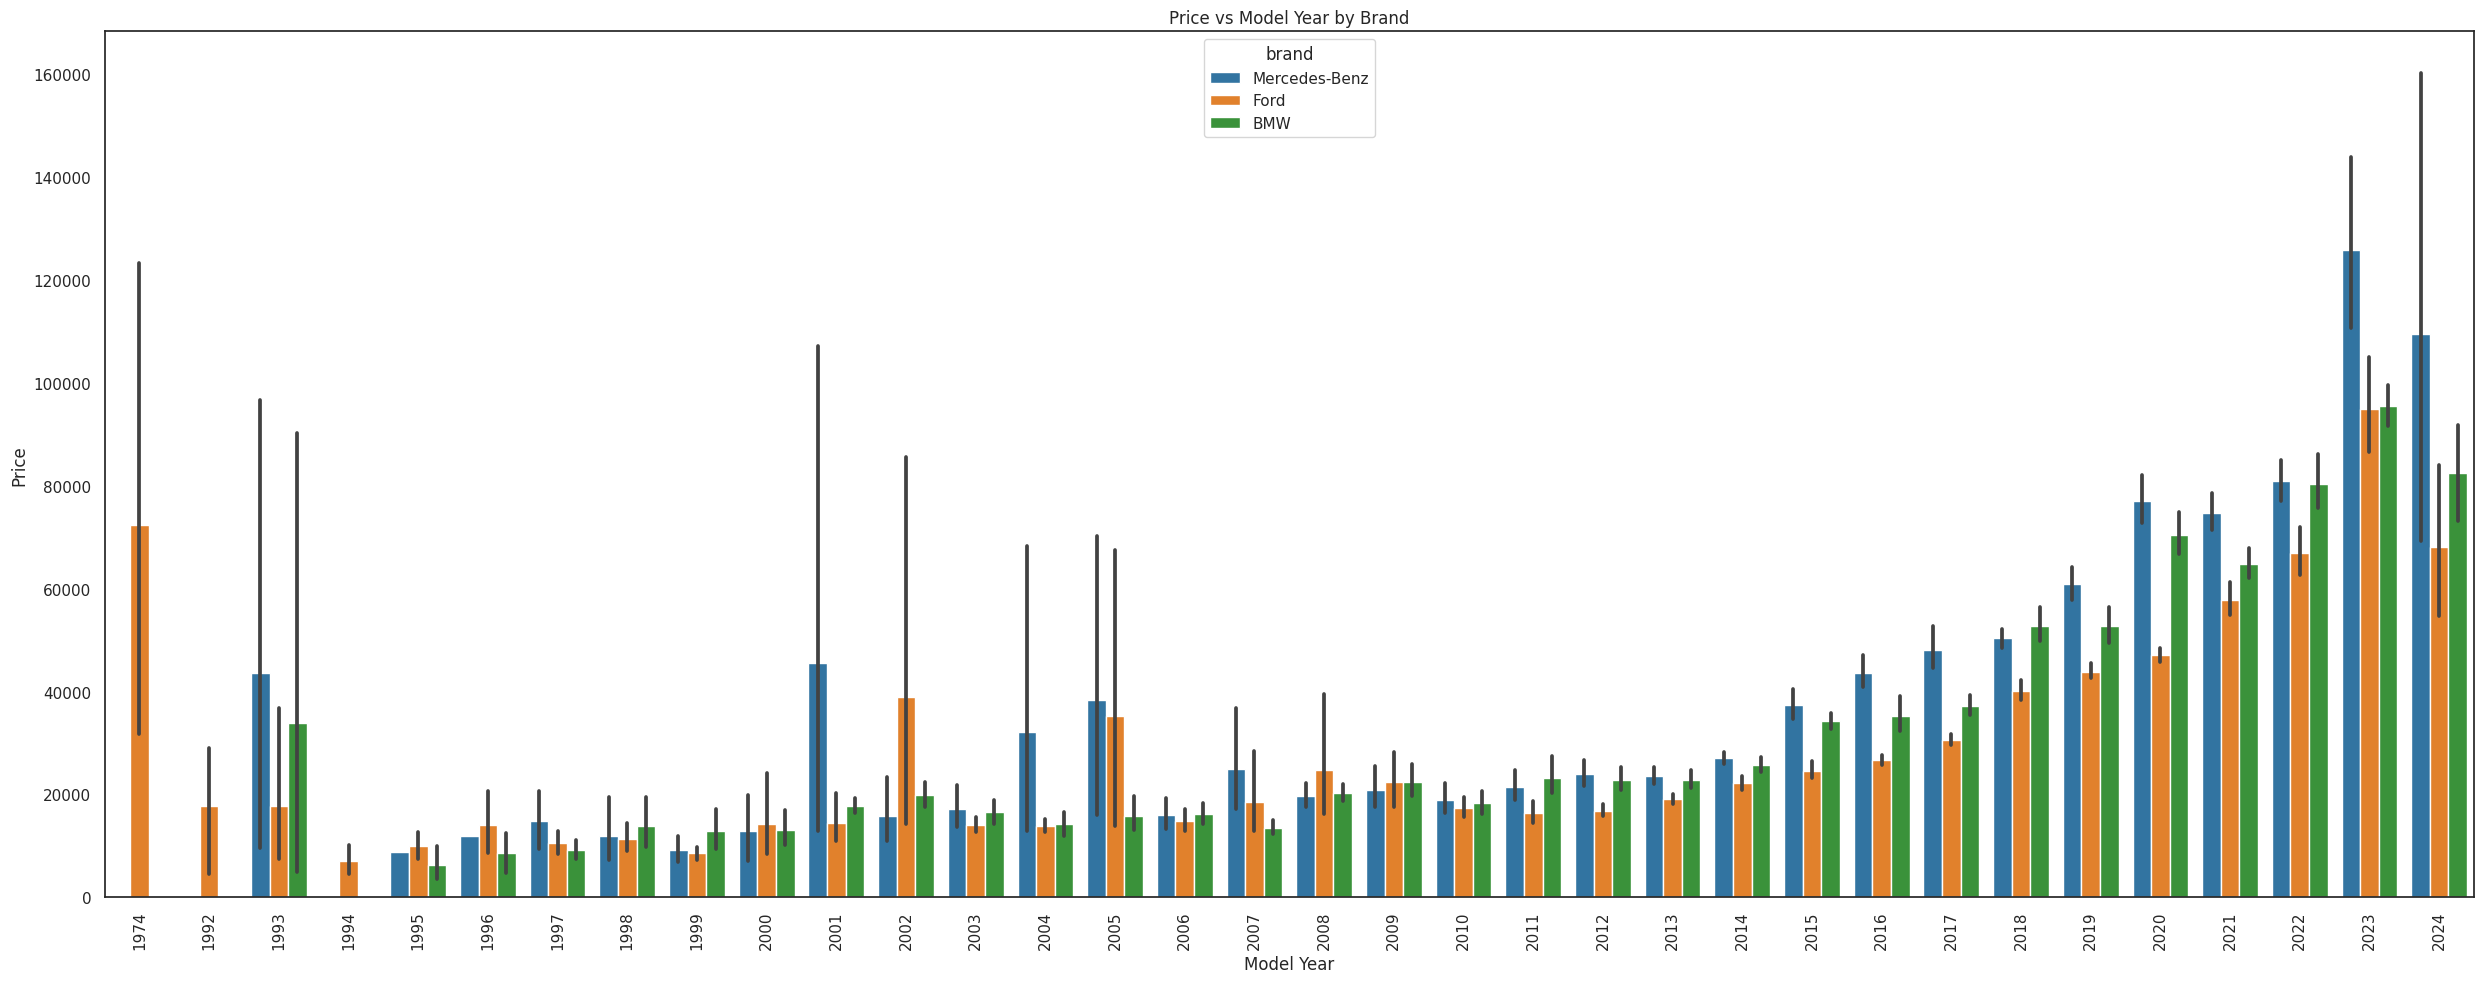

In [14]:
plt.figure(figsize=(25, 10))
sns.barplot(data=train_df, x="model_year", y="price", hue="brand")
plt.title("Price vs Model Year by Brand")
plt.xlabel("Model Year")
plt.ylabel("Price")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [15]:
top_10_model=train.model.value_counts().head(10)
top_10_model

model
F-150 XLT               2945
M3 Base                 2229
Camaro 2SS              1709
M4 Base                 1622
Mustang GT Premium      1526
F-150 Lariat            1410
E-Class E 350 4MATIC    1357
1500 Laramie            1249
911 Carrera S           1219
Corvette Base           1184
Name: count, dtype: int64

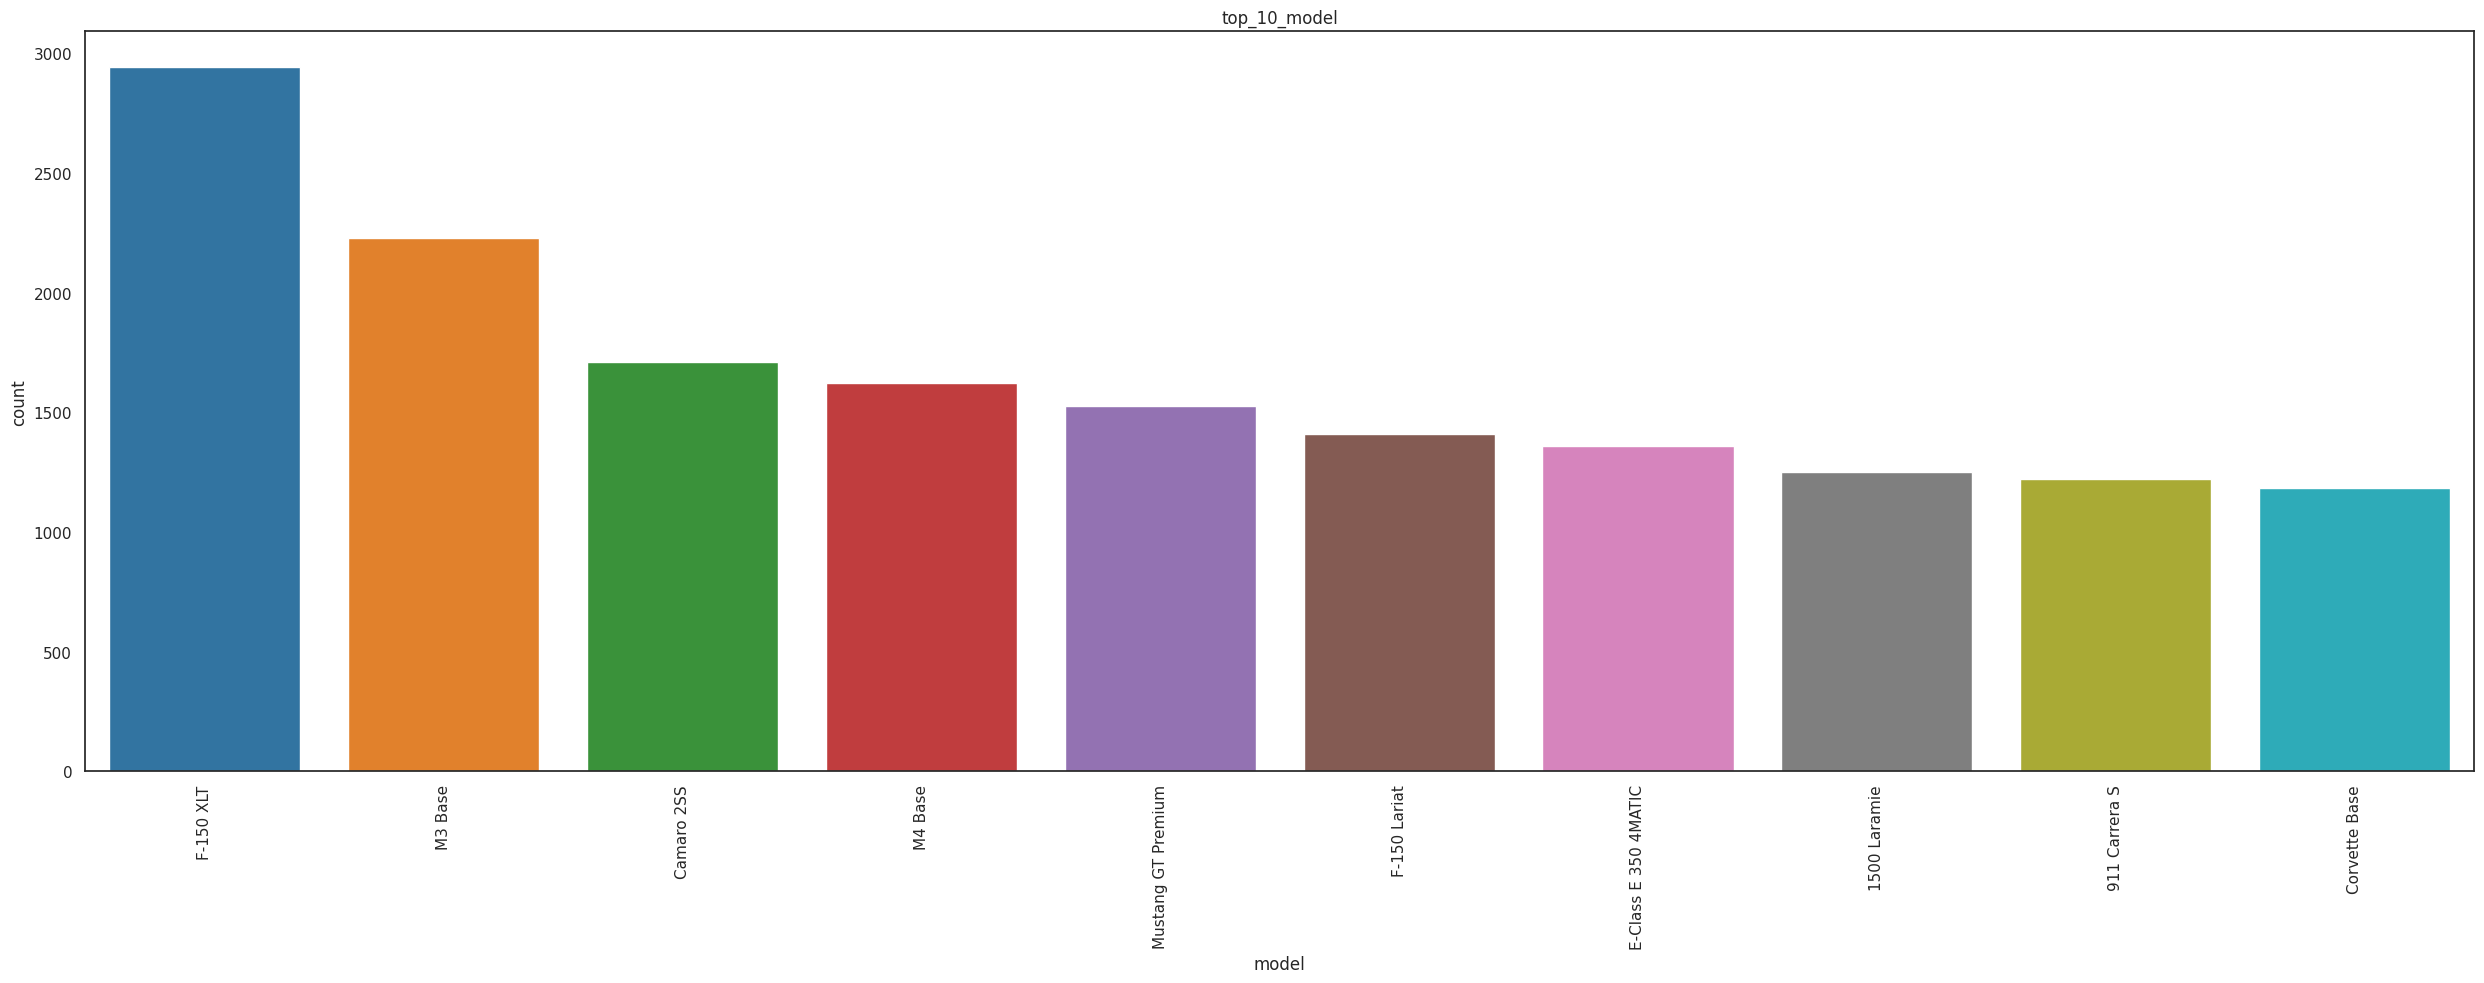

In [16]:
plt.figure(figsize=(25, 10))
sns.barplot(x=top_10_model.index, y=top_10_model.values)
plt.title("top_10_model")
plt.xlabel("model")
plt.ylabel("count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [17]:
train[train["milage"]==train["milage"].max()]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
24014,Ford,F-150 XLT,2018,405000,E85 Flex Fuel,385.0HP 5.0L 8 Cylinder Engine Flex Fuel Capab...,6-Speed A/T,White,Gray,At least 1 accident or damage reported,Yes,35000
36080,Chevrolet,Camaro 1SS,2019,405000,Gasoline,455.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,6-Speed M/T,Orange,Black,None reported,Yes,71950
45077,Toyota,Tacoma TRD Sport,2018,405000,Gasoline,278.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,6-Speed M/T,Black,Black,None reported,Yes,30000
45288,Toyota,Tacoma TRD Sport,2018,405000,Gasoline,278.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,6-Speed A/T,Black,Black,None reported,Yes,20995
61730,Porsche,911 Carrera Cabriolet,1998,405000,Gasoline,300.0HP 3.4L Flat 6 Cylinder Engine Gasoline Fuel,6-Speed M/T,Blue,Black,None reported,Yes,124995
126917,Volvo,S40 T5,2005,405000,Gasoline,218.0HP 2.5L 5 Cylinder Engine Gasoline Fuel,6-Speed M/T,Gold,Beige,None reported,Yes,10500
137357,Volkswagen,Golf GTI 2.0T SE 4-Door,2016,405000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed M/T,Blue,Black,None reported,Yes,18000
161337,Volkswagen,CC 2.0T Sport,2016,405000,Gasoline,200.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Gray,At least 1 accident or damage reported,Yes,17500


In [18]:
train.fuel_type.value_counts()

fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64

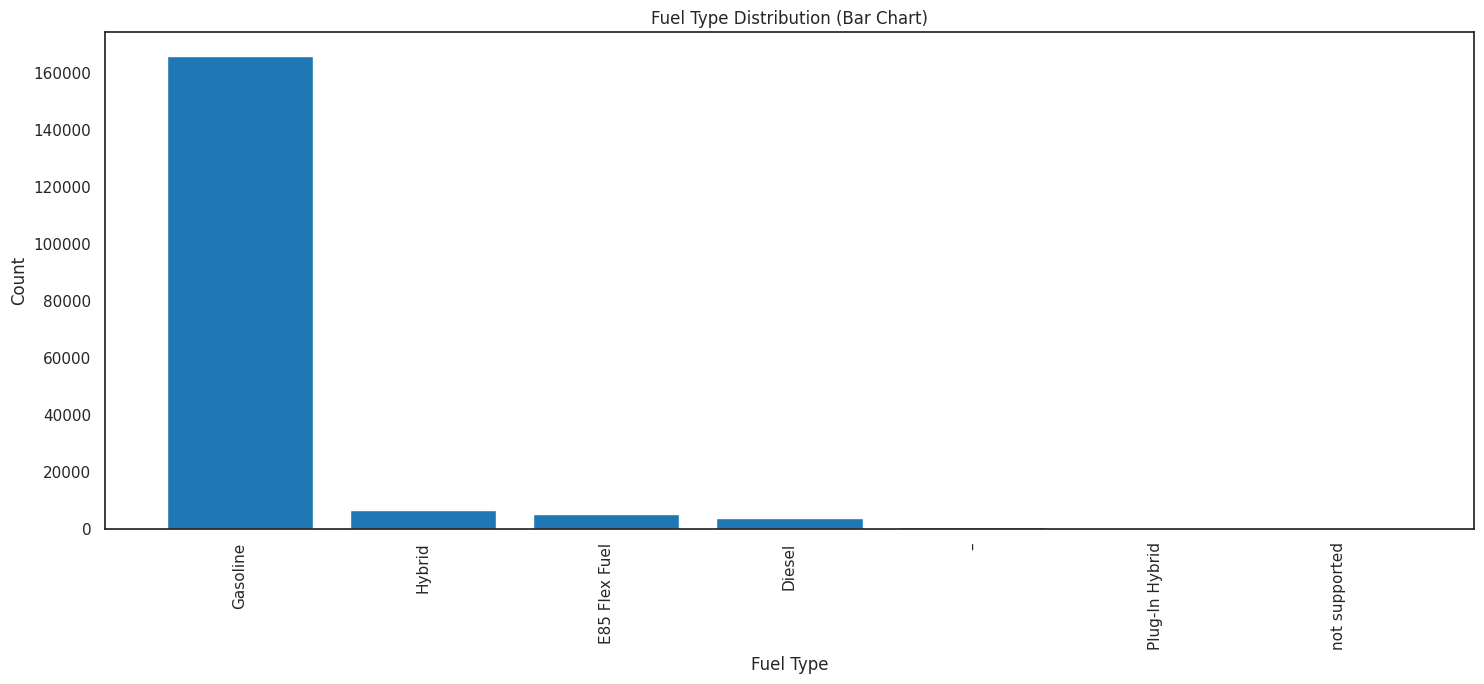

In [19]:
import plotly.express as px

# Bar plot for fuel type distribution
plt.figure(figsize=(15, 7))

plt.bar(train.fuel_type.value_counts().index, train.fuel_type.value_counts().values)
plt.title("Fuel Type Distribution (Bar Chart)")
plt.xticks(rotation=90)
plt.xlabel("Fuel Type")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# Pie chart using Plotly
fig = px.pie(
    names=train.fuel_type.value_counts().index,
    values=train.fuel_type.value_counts().values,
    title="Fuel Type Distribution (Pie Chart)"
)
fig.show()


In [20]:
top_10_engine=train.engine.value_counts().head(10)
top_10_engine

engine
355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel             3462
240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel             2902
420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel             2841
2.0L I4 16V GDI DOHC Turbo                               2680
375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel            2451
340.0HP 3.0L V6 Cylinder Engine Gasoline Fuel            2436
490.0HP 6.2L 8 Cylinder Engine Gasoline Fuel             2187
455.0HP 6.2L 8 Cylinder Engine Gasoline Fuel             2138
425.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel    2134
300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel    2084
Name: count, dtype: int64

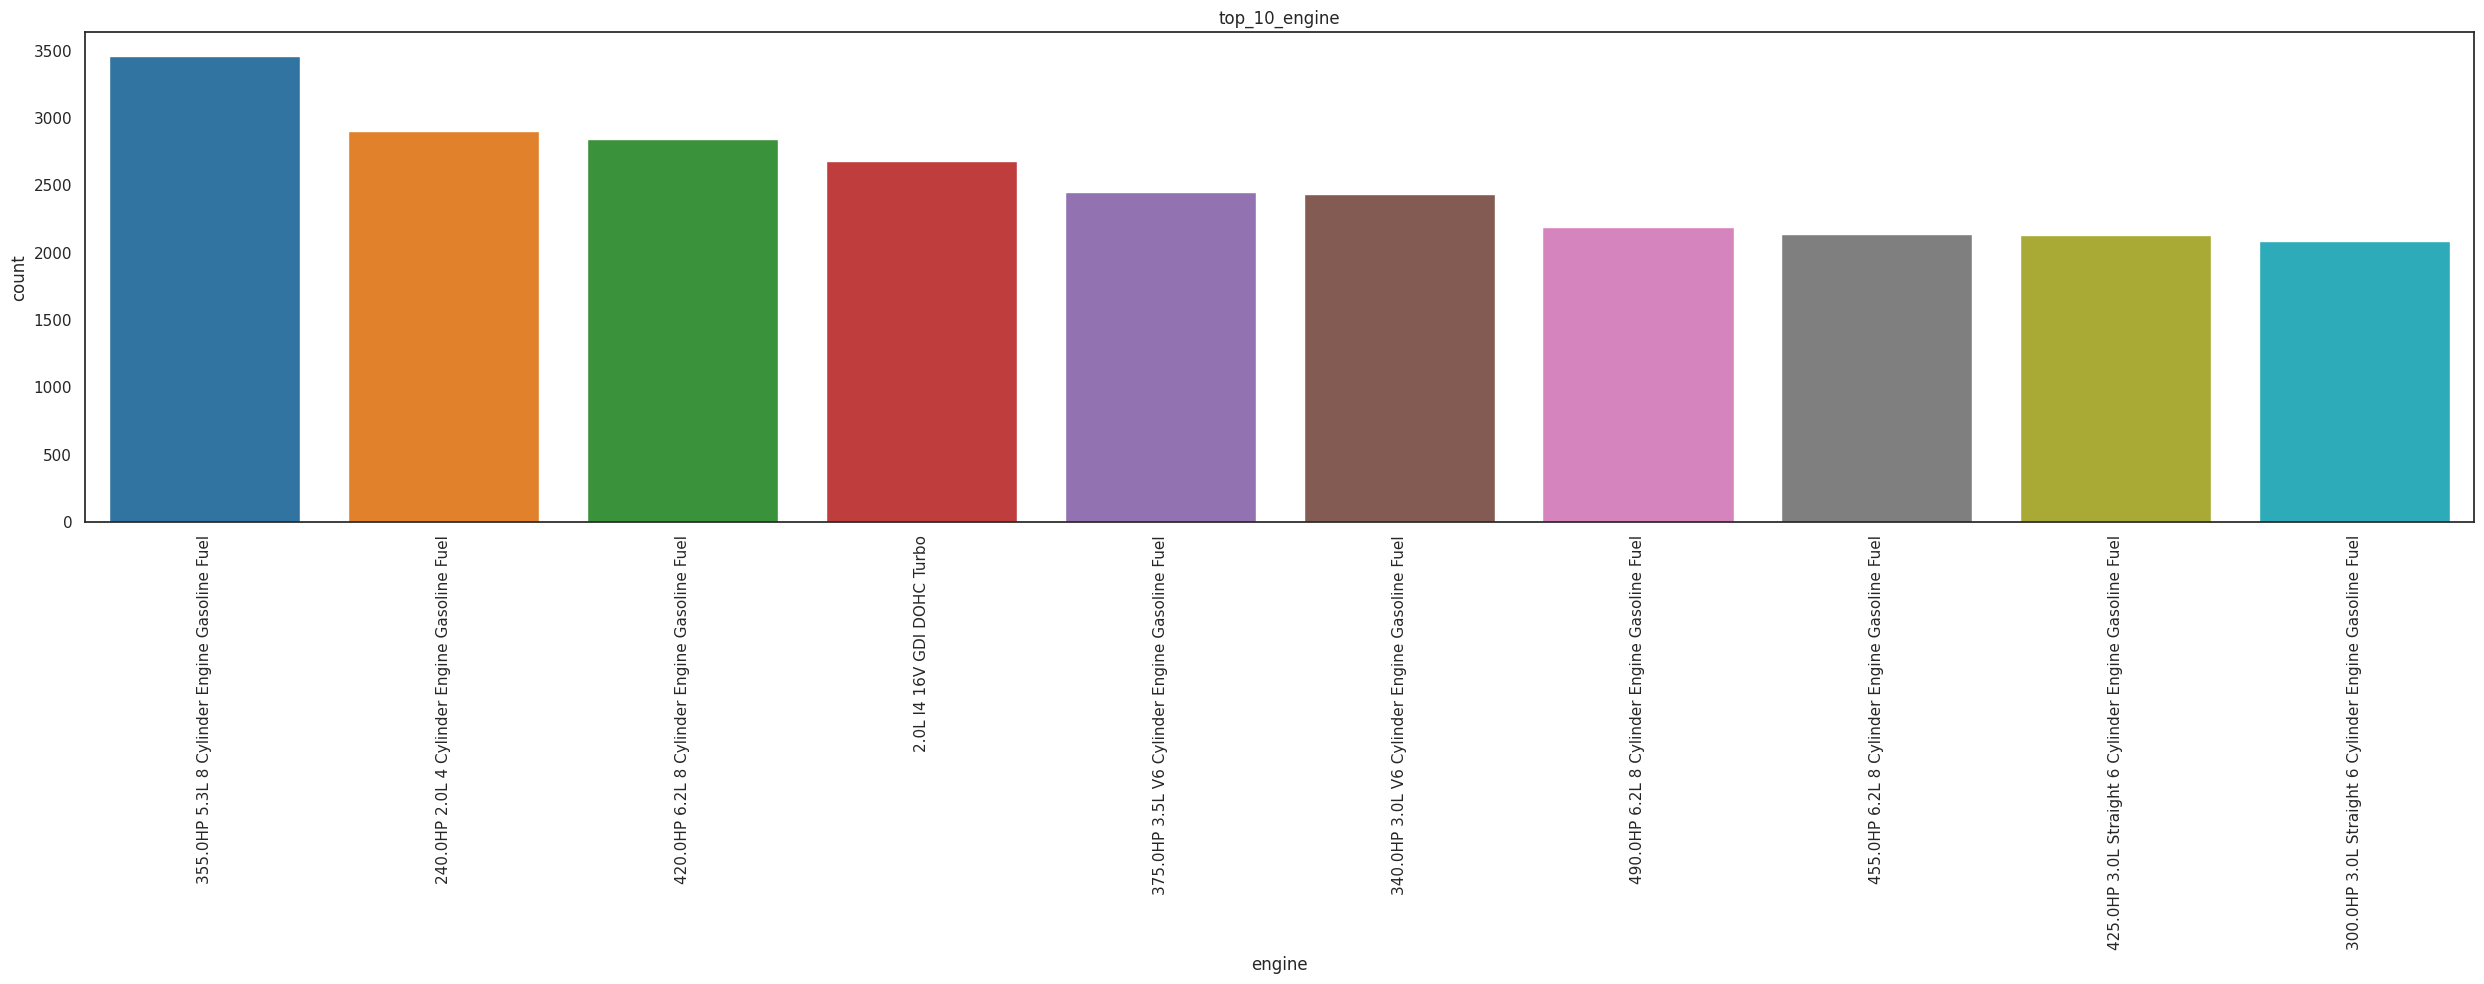

In [21]:
plt.figure(figsize=(25, 10))
sns.barplot(x=top_10_engine.index, y=top_10_engine.values)
plt.title("top_10_engine")
plt.xlabel("engine")
plt.ylabel("count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [22]:
train.transmission.value_counts()

transmission
A/T                                                   49904
8-Speed A/T                                           20645
Transmission w/Dual Shift Mode                        19255
6-Speed A/T                                           18044
6-Speed M/T                                           11998
7-Speed A/T                                           11124
Automatic                                             10691
8-Speed Automatic                                      8431
10-Speed A/T                                           8044
9-Speed A/T                                            3866
5-Speed A/T                                            3217
10-Speed Automatic                                     3164
6-Speed Automatic                                      2799
4-Speed A/T                                            2546
5-Speed M/T                                            2409
9-Speed Automatic                                      2325
CVT Transmission           

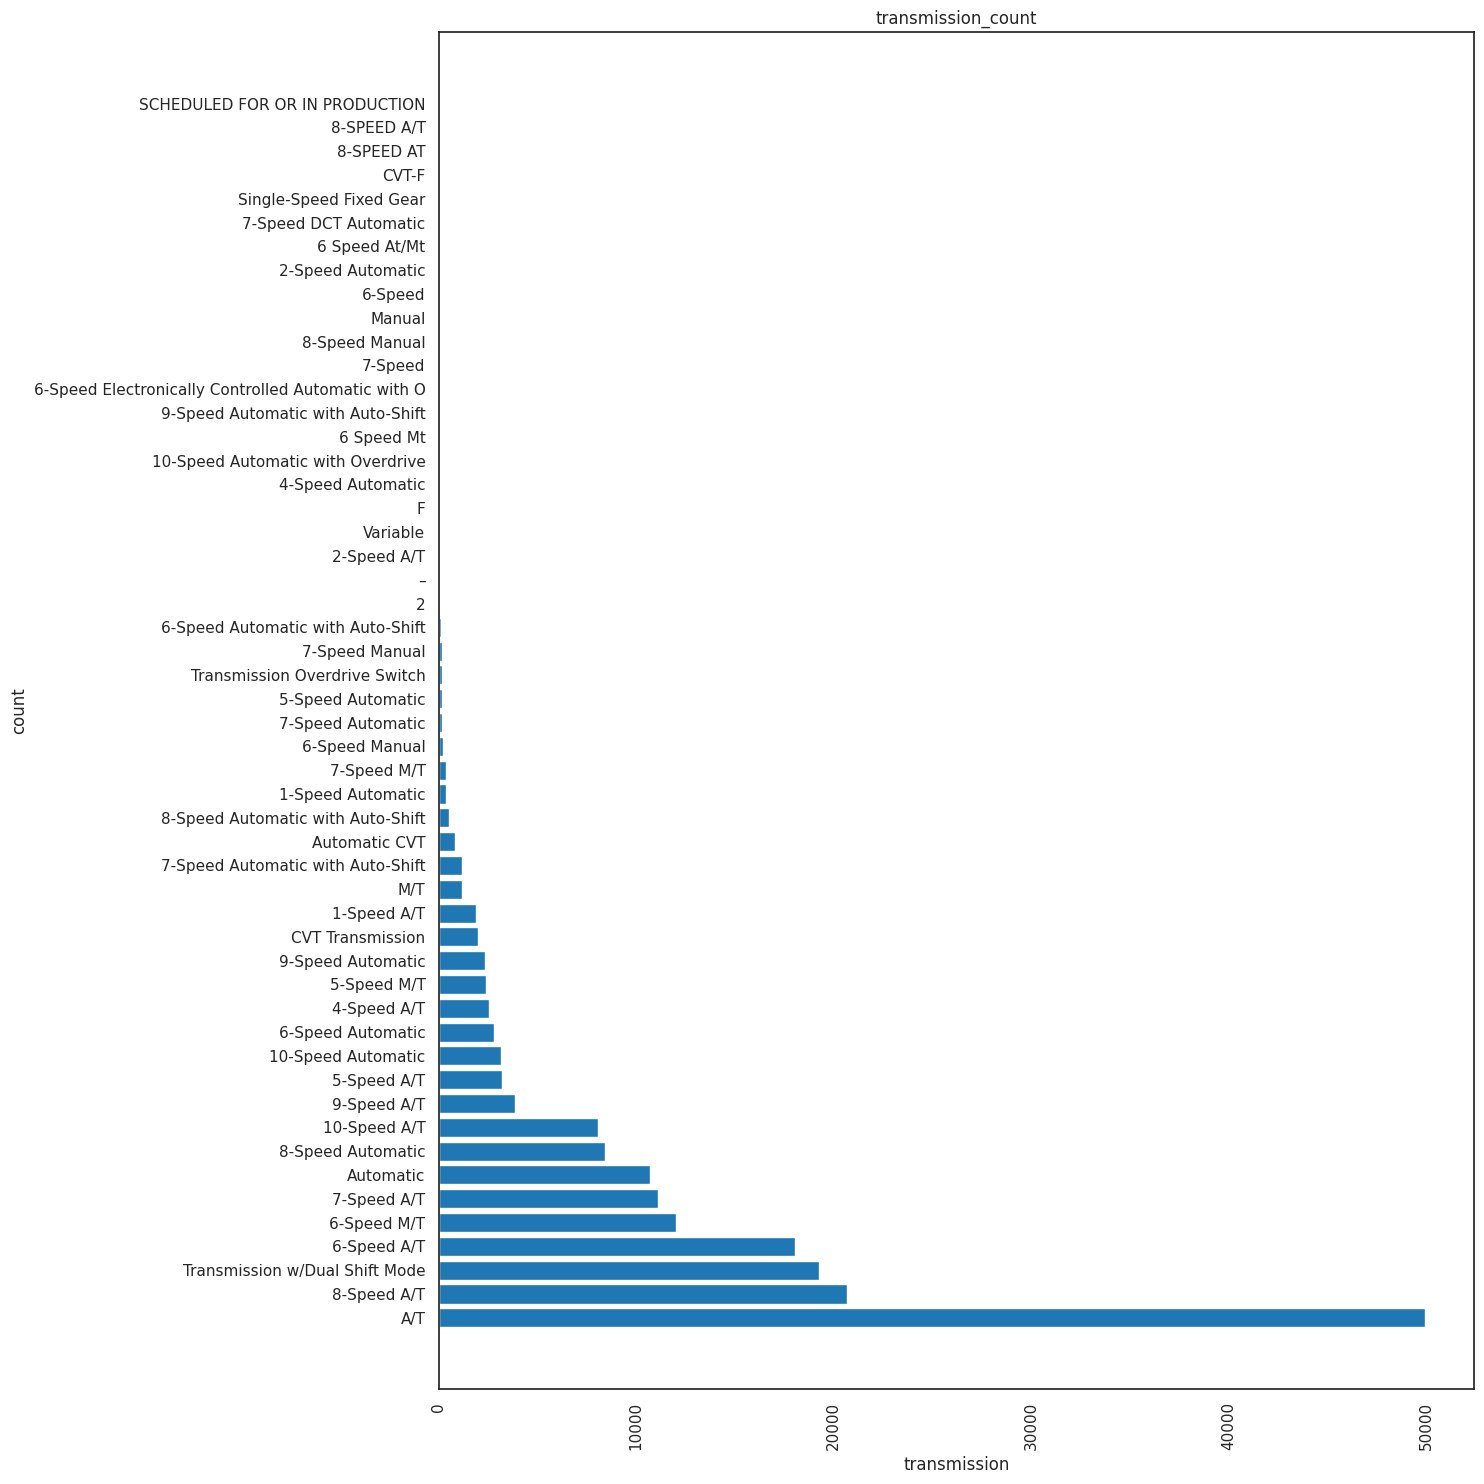

In [23]:
plt.figure(figsize=(15, 15))
plt.barh(train.transmission.value_counts().index, train.transmission.value_counts().values)
plt.title("transmission_count")
plt.xlabel("transmission")
plt.ylabel("count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [24]:
train.ext_col.value_counts()

ext_col
Black                                 48658
White                                 43815
Gray                                  25293
Silver                                16995
Blue                                  14555
                                      ...  
GT SILVER                                 5
Blue Caelum                               5
Granite Crystal Metallic Clearcoat        5
BLUE                                      3
Mango Tango Pearlcoat                     2
Name: count, Length: 319, dtype: int64

In [25]:
train.int_col.value_counts()

int_col
Black           107674
Beige            24495
Gray             21204
Brown             5810
Red               5145
                 ...  
Nougat Brown         7
Classic Red          7
Cobalt Blue          6
WHITE                6
ORANGE               4
Name: count, Length: 156, dtype: int64

In [26]:
train.accident.value_counts()

accident
None reported                             144514
At least 1 accident or damage reported     41567
Name: count, dtype: int64

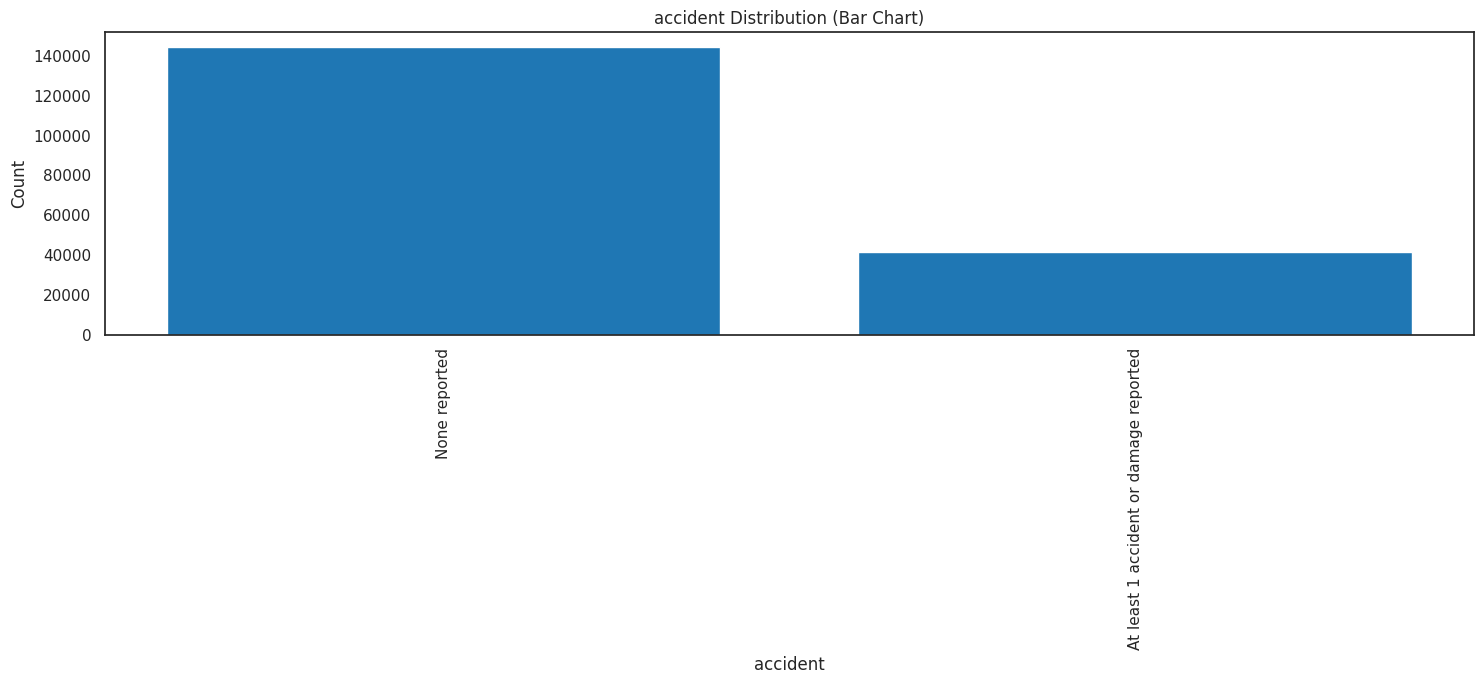

In [27]:
import plotly.express as px

# Bar plot for fuel type distribution
plt.figure(figsize=(15, 7))

plt.bar(train.accident.value_counts().index, train.accident.value_counts().values)
plt.title("accident Distribution (Bar Chart)")
plt.xticks(rotation=90)
plt.xlabel("accident")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# Pie chart using Plotly
fig = px.pie(
    names=train.accident.value_counts().index,
    values=train.accident.value_counts().values,
    title="accident Distribution (Pie Chart)"
)
fig.show()


# **Data Preprocessing**

In [28]:
test_df=test.copy()
test.drop(["id"],axis=1,inplace=True)
test_df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


In [29]:
test.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


> **Encoding**

In [30]:
le=LabelEncoder()
data=[train,test]
object_col=["brand","model","fuel_type","engine","transmission","ext_col","int_col","accident","clean_title"]
for i in data:
    for j in object_col:
        i[j]=le.fit_transform(i[j])

In [31]:
train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,31,495,2007,213000,2,116,38,312,71,1,0,4200
1,28,930,2002,143250,2,366,38,263,10,0,0,4999
2,9,1575,2002,136731,1,640,38,38,71,1,0,13900
3,16,758,2017,19500,2,863,49,29,14,1,0,45000
4,36,1077,2021,7388,2,259,23,29,10,1,0,97500


In [32]:
test.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,26,1388,2015,98000,2,326,16,302,10,1,0
1,26,1375,2020,9142,3,787,31,261,14,1,0
2,14,636,2022,28121,2,541,3,302,57,1,1
3,3,182,2016,61258,2,193,39,259,14,1,1
4,3,181,2018,59000,2,365,38,127,14,1,0


> **Missing_values**

In [33]:
imputer=SimpleImputer(missing_values=np.nan,strategy="mean")

for i in data:
    i=imputer.fit_transform(i)

In [34]:
train.isnull().sum()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64

In [35]:
test.isnull().sum()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
dtype: int64

> **Scale**

In [36]:
scaler=StandardScaler()
for i in data:
 #   for j in test.columns.to_list():
 #       i[j]=scaler.fit_transform(i[j].values.reshape(-1, 1))
    i["milage"]=scaler.fit_transform(i["milage"].values.reshape(-1, 1))
    i["model_year"]=scaler.fit_transform(i["model_year"].values.reshape(-1, 1))

In [37]:
train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,31,495,-1.559808,2.957842,2,116,38,312,71,1,0,4200
1,28,930,-2.443052,1.557184,2,366,38,263,10,0,0,4999
2,9,1575,-2.443052,1.426276,1,640,38,38,71,1,0,13900
3,16,758,0.206679,-0.927854,2,863,49,29,14,1,0,45000
4,36,1077,0.913274,-1.171076,2,259,23,29,10,1,0,97500


In [38]:
test.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,26,1388,-0.140564,0.636302,2,326,16,302,10,1,0
1,26,1375,0.740684,-1.132944,3,787,31,261,14,1,0
2,14,636,1.093183,-0.755054,2,541,3,302,57,1,1
3,3,182,0.035686,-0.095265,2,193,39,259,14,1,1
4,3,181,0.388185,-0.140224,2,365,38,127,14,1,0


In [39]:
X=train.drop(["price"],axis=1)
Y=train["price"]
Y=pd.DataFrame(Y)
X.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,31,495,-1.559808,2.957842,2,116,38,312,71,1,0
1,28,930,-2.443052,1.557184,2,366,38,263,10,0,0
2,9,1575,-2.443052,1.426276,1,640,38,38,71,1,0
3,16,758,0.206679,-0.927854,2,863,49,29,14,1,0
4,36,1077,0.913274,-1.171076,2,259,23,29,10,1,0


In [40]:
Y

,price
0,4200
1,4999
2,13900
3,45000
4,97500
...,...
188528,27500
188529,30000
188530,86900
188531,84900


In [41]:
scaler_Y=StandardScaler()
Y=scaler_Y.fit_transform(Y)
Y

array([[-0.50340474],
       [-0.49326763],
       [-0.38033846],
       ...,
       [ 0.54583048],
       [ 0.52045599],
       [-0.18882448]])

In [42]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=.3,random_state=42)
x_train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
69007,53,84,-0.853213,1.070217,2,345,38,304,14,0,0
68561,27,792,0.913274,-0.092138,2,810,17,263,122,1,1
22502,3,190,0.206679,-0.734272,2,610,38,263,14,1,0
4493,10,19,-1.206510,1.383523,1,495,38,263,71,0,0
32131,31,517,-0.323267,0.100299,2,146,20,304,14,1,0


# **ML Models**

In [43]:
MultiLinear=LinearRegression()
LassoModel=Lasso(alpha=1)
RidgeModel=Ridge(alpha=1)
svr=SVR(kernel='rbf',C=2)
tree=DecisionTreeRegressor(max_depth=15,max_features=7,random_state=42)
forest=RandomForestRegressor(n_estimators=150,max_depth=15,max_features=7,random_state=42)
AdaModel=AdaBoostRegressor(n_estimators=100,learning_rate=1,random_state=42)
Grad=GradientBoostingRegressor(n_estimators=150,learning_rate=1,random_state=42)
XgbModel=XGBRegressor()
voting=VotingRegressor(estimators=[("LinearRegression",MultiLinear),("Lasso",Lasso),("Ridge",RidgeModel),("SVR",svr),("DecisionTreeRegressor",tree),
                                  ("RandomForestRegressor",forest),("AdaBoostRegressor",AdaModel),
                                   ("GradientBoostingRegressor",Grad),("XGBRegressor",XgbModel)])

In [44]:
Models=[MultiLinear,LassoModel,RidgeModel,tree,forest,AdaModel,Grad,XgbModel]

In [ ]:
for model in Models:
    print(f"__________________________________________________________________________________________________\n===>>{model}\n")
    model.fit(x_train,y_train)
    Y_pred=model.predict(x_test)
    print(f"======> Y_pred : \n{Y_pred}\n")
    # Evaluate the model
    mae = mean_absolute_error(y_test, Y_pred)
    mse = mean_squared_error(y_test, Y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, Y_pred)

    # Print the evaluation results
    print(f'Mean Absolute Error (MAE): {mae:.2f}')
    print(f'Mean Squared Error (MSE): {mse:.2f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
    print(f'R² Score: {r2:.2f}')

__________________________________________________________________________________________________
===>>LinearRegression()

======> Y_pred : 
[[ 0.32534708]
 [-0.02709182]
 [-0.1780359 ]
 ...
 [-0.43726716]
 [-0.03396714]
 [-0.30755771]]

Mean Absolute Error (MAE): 0.29
Mean Squared Error (MSE): 0.75
Root Mean Squared Error (RMSE): 0.87
R² Score: 0.12
__________________________________________________________________________________________________
===>>Lasso(alpha=1)

======> Y_pred : 
[-0.05549751 -0.15306759 -0.03402993 ... -0.22551555 -0.01092566
 -0.16274284]

Mean Absolute Error (MAE): 0.33
Mean Squared Error (MSE): 0.81
Root Mean Squared Error (RMSE): 0.90
R² Score: 0.05
__________________________________________________________________________________________________
===>>Ridge(alpha=1)

======> Y_pred : 
[[ 0.32534117]
 [-0.02710223]
 [-0.17803263]
 ...
 [-0.43726519]
 [-0.03397161]
 [-0.3075567 ]]

Mean Absolute Error (MAE): 0.29
Mean Squared Error (MSE): 0.75
Root Mean Squar

In [ ]:
prediction = scaler_Y.inverse_transform(Grad.predict(test).reshape(-1, 1)).flatten()

In [ ]:
test.head()

In [ ]:
submission = pd.DataFrame({
    "id": test_df["id"].astype(int),  
    "price": prediction
})

submission.to_csv('submission.csv', index=False)

In [ ]:
submission.head()